In [13]:
from sklearn.svm import OneClassSVM
import numpy as np
import warnings
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import sys
sys.path.append('../induction_motor_anomaly_detection/')
import modules,scaler

In [2]:
normal_data = pd.read_csv('../data/combined_data.csv')
anomalous_data = pd.read_csv('../anomalous_data/anomalous_data.csv')


In [3]:
train_data_features = modules.ElectricalFeatureExtractor(current_data=normal_data)
test_data_features = modules.ElectricalFeatureExtractor(current_data=anomalous_data)
train_scaler = scaler.Scaler()
train_scaler.fit_unlabelled_data(train_data_features.feature_dataframe[0])
train_scaled = train_scaler.transform(train_data_features.feature_dataframe[0])
test_scaled = train_scaler.transform(test_data_features.feature_dataframe[0])

In [4]:

class AnomalyDetector:
    def __init__(self, kernel='rbf', nu=0.1, gamma='auto', window_size=1000):
        self.kernel = kernel
        self.nu = nu
        self.gamma = gamma
        self.window_size = window_size
        self.clf = None
        self.X_train = np.array([])

    def fit(self, X):
        """
        Fit the OneClassSVM to the training data.
        """
        if self.clf is None:
            self.clf = OneClassSVM(kernel=self.kernel, nu=self.nu, gamma=self.gamma)
            self.X_train = X
            self.clf.fit(X)
        else:
            self.X_train = np.concatenate((self.X_train, X), axis=0)
            self.clf.fit(self.X_train[-self.window_size:])

    def predict(self, X_test):
        """
        Predict whether the data is anomalous or not based on the OneClassSVM.
        """
        is_anomaly = self.clf.predict(X_test) == -1
        return is_anomaly


In [7]:
anomaly_detector = AnomalyDetector(kernel='rbf', nu=0.1, gamma='auto', window_size=1000)

it = iter(train_scaled)
try:
    while True:
        data = next(it)
        anomaly_detector.fit([data])
except StopIteration:
    pass


In [8]:
anomaly_predictions = anomaly_detector.predict(train_scaled)

In [11]:
np.where(anomaly_predictions == True)[0]

array([ 12, 164, 175, 180, 197, 198, 202, 203, 204, 205, 206, 209, 211,
       212, 213, 215, 217, 220, 224, 228, 229, 230, 231, 232, 234, 235,
       239, 240, 242, 255, 271, 307], dtype=int64)

In [12]:
anomaly_detector.predict(test_scaled)

array([ True])

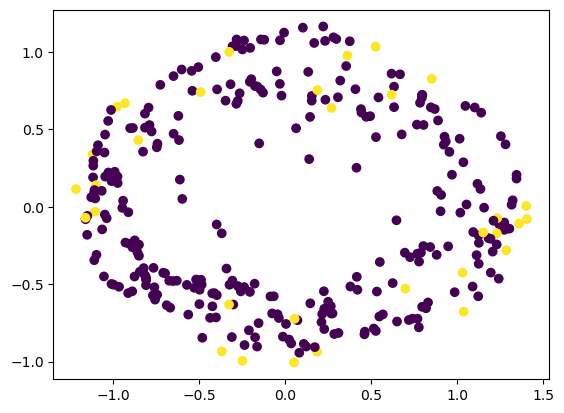

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# assuming you have already scaled and preprocessed the data and stored it in variable X

pca = PCA(n_components=2)
X_2d = pca.fit_transform(train_scaled)

# assuming you have already fit the anomaly detection model and stored it in variable anomaly_detector
anomaly_predictions = anomaly_detector.predict(train_scaled)

# scatter plot of the data points colored by anomaly label
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=anomaly_predictions)
plt.show()
